## Divisive Clustering With Coresets Using CUDA-Q  
Reference: https://nvidia.github.io/cuda-quantum/latest/applications/python/divisive_clustering_coresets.html  

Clustering is a common unsupervised learning technique aimed at grouping data with similar characteristics. The unique properties of quantum computers could allow for enhanced pattern finding in clustering applications and enable more reliable data analysis. However, quantum computers today are severely limited by qubit count and noise. Performing practical clustering applications would require far too many qubits. The Edinburgh team developed a new method (extending the work of Harrow) to leverage coresets for clustering applications on quantum computers and use far fewer qubits. This tutorial will walk through an example using this approach for divisive clustering and emphasize the utility of CUDA-Q for scaling quantum simulations.

The goal of divisive clustering is to begin with all data points as one set, and iteratively bipartition the data until each point is its own cluster. The branching behavior of this process can be used to understand similarities in the data points.

In [116]:
# If you are running outside of a CUDA-Q container or CUDA-Q directory tree, you may need to uncomment these lines to fetch the files.
# If you are running inside a CUDA-Q tree, then this step can be skipped.
!mkdir divisive_clustering_src
!wget -P divisive_clustering_src https://raw.githubusercontent.com/NVIDIA/cuda-quantum/main/docs/sphinx/applications/python/divisive_clustering_src/divisive_clustering.py
!wget -P divisive_clustering_src https://raw.githubusercontent.com/NVIDIA/cuda-quantum/main/docs/sphinx/applications/python/divisive_clustering_src/main_divisive_clustering.py

mkdir: cannot create directory ‘divisive_clustering_src’: File exists
--2026-01-28 17:59:20--  https://raw.githubusercontent.com/NVIDIA/cuda-quantum/main/docs/sphinx/applications/python/divisive_clustering_src/divisive_clustering.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44575 (44K) [text/plain]
Saving to: ‘divisive_clustering_src/divisive_clustering.py.3’

divisive_clustering 100%[===================>]  43.53K  --.-KB/s    in 0.002s  

2026-01-28 17:59:20 (19.8 MB/s) - ‘divisive_clustering_src/divisive_clustering.py.3’ saved [44575/44575]

--2026-01-28 17:59:21--  https://raw.githubusercontent.com/NVIDIA/cuda-quantum/main/docs/sphinx/applications/python/divisive_clustering_src/main_divisive_clustering.py
Resolving raw.githubusercontent.com (raw.git

In [117]:
import cudaq
from cudaq import spin

# Auxillary Imports
import os
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from typing import Tuple
from divisive_clustering_src.divisive_clustering import Coreset, DivisiveClustering, Dendrogram, Voironi_Tessalation

warnings.filterwarnings("ignore")

In [118]:
# Global Parameters for the quantum simulation
DEPTH = 2
max_iterations = 50
max_shots = 1024
np.random.seed(10)

Given a data set $X = (x_1, x_2, \dots, x_N)$, a coreset is weighted data set of much smaller size $(X^{'}, w)$ that represents $X$ enough such that analysis of $(X^{'}, w)$ can allow us to draw resonable approximate conclusions about $X$. There are various approaches to build coresets.  

Essentially, coreset construction boils down to finding the optimal coreset size and weights given some error tolerance. Given the constraints of a quantum computer, in this work, a coreset size is selected *a priori*, and the error is determined for each model.  

The following is an example $M = 10$ coreset constructed from a 1000-oint data set and loaded into a pandas data frame. See the image below where the coreset is represented by teh black stars, the size of which corresponds to the weights

In [119]:
raw_data =Coreset.create_dataset(1000)
coreset = Coreset(raw_data,
                  number_of_sampling_for_centroids=10, 
                  coreset_size = 10,
                  number_of_coresets_to_evaluate= 4,
                  coreset_method = "BFL2")

coreset_vectors, coreset_weights = coreset.get_best_coresets()

coreset_df = pd.DataFrame({
    "X": coreset_vectors[:, 0],
    "Y": coreset_vectors[:, 1],
    "weights": coreset_weights
})
coreset_df["Name"] = [chr(i + 65) for i in coreset_df.index]
print(coreset_df)

Using BFL2 method to generate coresets
          X         Y     weights Name
0  6.462902  2.594957   49.613217    A
1  0.051144  0.232842  276.595841    B
2 -0.450107 -0.746274   87.302679    C
3  8.034959  0.775580  144.561264    D
4  1.291564  0.043612  126.143762    E
5  0.254036  0.506646  152.433595    F
6  6.131545  1.726027   44.296573    G
7 -0.107979 -0.707216   92.679946    H
8  8.090555  0.281354   87.716384    I
9 -1.230102  0.155939   65.063094    J


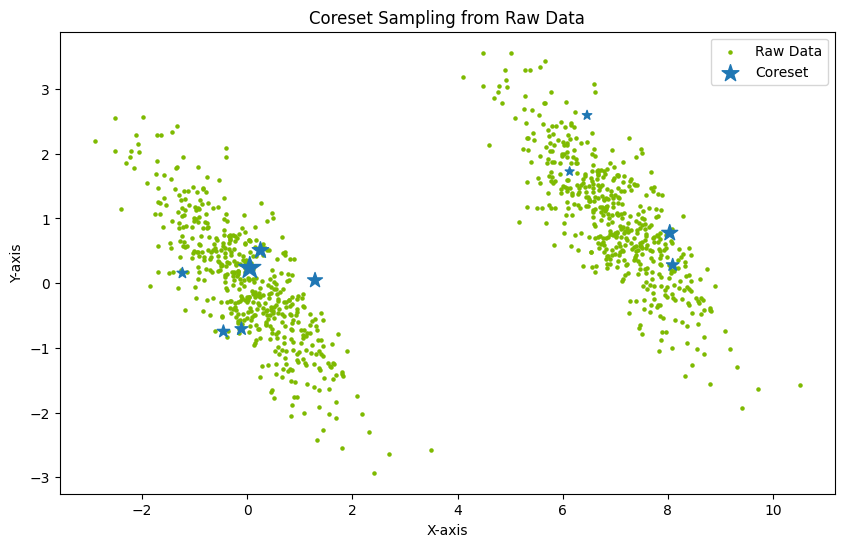

In [120]:
plt.figure(figsize=(10, 6))

plt.scatter(raw_data[:, 0], raw_data[:, 1], s=5, label="Raw Data", c = '#7eba00')
plt.scatter(coreset_df["X"], coreset_df["Y"], s=coreset_df["weights"], label="Coreset",  marker= '*')
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Coreset Sampling from Raw Data")
plt.legend()
plt.show()

### Preprocessing  
In order to cluster data on a quantum computer, the task needs to be cast into the form of a binary optimization problem. Each qubit represents a coreset point, and the quantum algorithm determines how to bipartition the coreset points at each iteration of the divisive clustering routine.

The first step is to convert coreset points into a fully connected graph. The edge weight is calculated by:  
$e_{ij}=w_{i}w_{j}d_{ij}$ where $d_{ij}$ is the Duclidean distance between points $i$, $j$.  

This process is handled by ```Coreset.coreset_to_graph()```. The fnction returns a fully connected graph $G$ with edge weights

### Quantum functions  
The divisive clustering problem will be implemented on a quantum computer using a variational quantum algorithm (VQA) approach. A VQA takes a Hamiltonian (encoded with the optimization problem) and a parameterized ansatz and evaluates expectation values (quantum computer) that inform updates to the ansatz parameters (classical computer). The graph $G$ (Code in the “src” file) is used to construct the Hamiltonian, derived specifically for the divisive clustering problem, and motivated by a max-cut Hamiltonian. The ```spin.z(i)``` method in CUDA-q adds a Pauli Z oprations that acts on qubit $i$ to the Hamiltonian

In [121]:
def get_K2_H(G: nx.Graph) -> cudaq.SpinOperator:
    """Returns the K2 Hamiltonian for the given graph G

    Args:
        G (nx.Graph): Weighted graph
    """
    H = 0

    for i, j in G.edges():
        weight = G[i][j]["weight"]
        H += weight * (spin.z(i) * spin.z(j))

    return H

The code below constructs a quantum kernel, defining the circuit which will serve as an ansatz. The structure of the circuit is a hardware efficient ansatz consisting of layers of parameterized $R_Z$ and $R_Y$ gate acting on each qubit, followed by a linear cascade of CNOT gates, and two more rotation gates  

The ```@cudaq.kernel``` decorator allows us to define a quantum circuit in the new kernel mode syntax which provides performance bnenfits to JIT compilation.

In [122]:
def get_VQE_circuit(number_of_qubits: int, circuit_depth: int) -> cudaq.Kernel:
    """Returns the VQE circuit for the given number of qubits and circuit depth

    Args:
        number_of_qubits (int): Number of qubits
        circuit_depth (int): Circuit depth

    Returns:
        cudaq.Kernel: VQE Circuit
    """

    @cudaq.kernel
    def kernel(thetas: list[float], number_of_qubits: int, circuit_depth: int):
        """VQE Circuit

        Args:
            thetas (list[float]): List of parameters
            number_of_qubits (int): Number of qubits
            circuit_depth (int): Circuit depth
        """
        qubits = cudaq.qvector(number_of_qubits)

        theta_position = 0

        for i in range(circuit_depth):
            for j in range(number_of_qubits):
                ry(thetas[theta_position], qubits[j])
                rz(thetas[theta_position + 1], qubits[j])

                theta_position += 2

            for j in range(number_of_qubits - 1):
                cx(qubits[j], qubits[j + 1])

            for j in range(number_of_qubits):
                ry(thetas[theta_position], qubits[j])
                rz(thetas[theta_position + 1], qubits[j])

                theta_position += 2

    return kernel

We can visualize the ciruit using the ```cudaq.draw()``` method.

In [123]:
NUM_QUBITS = 5
DEPTH = 2
parameter_count = 4 * DEPTH * NUM_QUBITS
parameters = np.random.rand(parameter_count)

circuit = get_VQE_circuit(NUM_QUBITS, DEPTH)
print(cudaq.draw(circuit, parameters, NUM_QUBITS, DEPTH))

     ╭────────────╮╭────────────╮     ╭────────────╮╭────────────╮»
q0 : ┤ ry(0.7442) ├┤ rz(0.1862) ├──●──┤ ry(0.8638) ├┤ rz(0.1269) ├»
     ├────────────┤├───────────┬╯╭─┴─╮╰────────────╯├────────────┤»
q1 : ┤ ry(0.4138) ├┤ rz(0.231) ├─┤ x ├──────●───────┤ ry(0.3709) ├»
     ├────────────┤├───────────┴╮╰───╯    ╭─┴─╮     ╰────────────╯»
q2 : ┤ ry(0.6536) ├┤ rz(0.7644) ├─────────┤ x ├───────────●───────»
     ├────────────┤├────────────┤         ╰───╯         ╭─┴─╮     »
q3 : ┤ ry(0.8349) ├┤ rz(0.2122) ├───────────────────────┤ x ├─────»
     ├───────────┬╯├────────────┤                       ╰───╯     »
q4 : ┤ ry(0.962) ├─┤ rz(0.2611) ├─────────────────────────────────»
     ╰───────────╯ ╰────────────╯                                 »

################################################################################

╭─────────────╮╭────────────╮                             ╭────────────╮»
┤ ry(0.02343) ├┤ rz(0.9351) ├─────────────────────●───────┤ ry(0.1616) ├»
├────────────┬╯├─────

THe next step is to select a classical optimizer. There are multiple optimizers built-in to CUdA-Q that can be selected. The code below returns the optimizer with the proper number of initial parameters.

In [124]:
def get_optimizer(optimizer: cudaq.optimizers.optimizer, max_iterations,
                  **kwargs) -> Tuple[cudaq.optimizers.optimizer, int]:
    """Returns the optimizer with the given parameters

    Args:
        optimizer (cudaq.optimizers.optimizer): Optimizer
        max_iterations (int): Maximum number of iterations
        **kwargs: Additional arguments

    Returns:
        tuple(cudaq.optimizers.optimizer, int): Optimizer and parameter count
    """
    parameter_count = 4 * kwargs["circuit_depth"] * kwargs["qubits"]
    initial_params = np.random.uniform(-np.pi / 8.0, np.pi / 8.0,
                                       parameter_count)
    optimizer.initial_parameters = initial_params

    optimizer.max_iterations = max_iterations
    return optimizer, parameter_count

## Divisive Clustering Function  
The ```DivisiveClusteringVQA``` class enables the procedure to iteratively biparition the coreset points until each is tis own cluster.  

```run_divisive_clustering```, takes the current iterations's coreset points that will be bipartitioned as inputs, extracts the appropriate weights, and builds a graph $G$. The graph is then an input into the ```get_counts_from_simulation``` function.  

```get_counts_from_simulation``` handles preparation and execution of the quantum simulation. First, it takes $G$ and from it builds a spin Hamiltonian. Second, it defines a cost function, which in this case is a lambda function that returns the expectation value of our parameterized quantum circuit and the Hamiltonian. This value is obtained using the CUDA-Q ```observe``` command, accelerate by GPUs. After the expectation value is minimized, the quantum circuit corresponding to the optimal parameters is sampled the CUDA-Q ```sample``` function. The bitstrings and their associated counts are returned by ```get_counts_from_simulation```  

A subset of these counts is evaluated to compute their exact cost. The bset bitstring is returned and later used to assign the coreset points to one of two clusters.

In [125]:
class DivisiveClusteringVQA(DivisiveClustering):

    def __init__(
        self,
        **kwargs,
    ):
        super().__init__(**kwargs)

    def run_divisive_clustering(
        self,
        coreset_vectors_df_for_iteration: pd.DataFrame,
    ):
        """Runs the Divisive Clustering algorithm

        Args:
            coreset_vectors_df_for_iteration (pd.DataFrame): Coreset vectors for the iteration

        Returns:
            str: Best bitstring

        """
        coreset_vectors_for_iteration_np, coreset_weights_for_iteration_np = (
            self._get_iteration_coreset_vectors_and_weights(
                coreset_vectors_df_for_iteration))

        G = Coreset.coreset_to_graph(
            coreset_vectors_for_iteration_np,
            coreset_weights_for_iteration_np,
            metric=self.coreset_to_graph_metric,
        )

        counts = self.get_counts_from_simulation(
            G,
            self.circuit_depth,
            self.max_iterations,
            self.max_shots,
        )

        return self._get_best_bitstring(counts, G)

    def get_counts_from_simulation(self, G: nx.graph, circuit_depth: int,
                                   max_iterations: int,
                                   max_shots: int) -> cudaq.SampleResult:
        """
        Runs the VQA simulation

        Args:
            G (nx.graph): Graph
            circuit_depth (int): Circuit depth
            max_iterations (int): Maximum number of iterations
            max_shots (int): Maximum number of shots

        Returns:
            cudaq.SampleResult: Measurement from the experiment
        """

        qubits = len(G.nodes)
        Hamiltonian = self.create_Hamiltonian(G)
        optimizer, parameter_count = self.optimizer_function(
            self.optimizer,
            max_iterations,
            qubits=qubits,
            circuit_depth=circuit_depth)

        kernel = self.create_circuit(qubits, circuit_depth)

        def objective_function(
            parameter_vector: list[float],
            hamiltonian: cudaq.SpinOperator = Hamiltonian,
            kernel: cudaq.Kernel = kernel,
        ) -> float:
            """

            Objective function that returns the cost of the simulation

            Args:
                parameter_vector (List[float]):
                hamiltonian (cudaq.SpinOperator): Circuit parameter values as a vector
                kernel (cudaq.Kernel) : Circuit configuration

            Returns:
                float: Expectation value of the circuit

            """

            get_result = lambda parameter_vector: cudaq.observe(
                kernel, hamiltonian, parameter_vector, qubits, circuit_depth
            ).expectation()

            cost = get_result(parameter_vector)

            return cost

        energy, optimal_parameters = optimizer.optimize(
            dimensions=parameter_count, function=objective_function)

        counts = cudaq.sample(kernel,
                              optimal_parameters,
                              qubits,
                              circuit_depth,
                              shots_count=max_shots)

        return counts

As instance of the ```DivisiveClusteringVQA``` class is mostly constructed from variables previously discussed like the functions for building the Hamiltonians and quantum circuits. Parameters related to the quantum simulation can also be specified here such as ```circuit_depth``` and ```max_shots```. The ```threshold_for_max_cut``` parameter specifies what percent of the sample results from the quantum computer are checked for the best bistring value.  

The other options specify advanced features like if the data is normalized and how the graph weights are computed  

Finally, the ```get_division_sequence``` method performs the iterations and produces the clustring data which we will analyze below. Note that this postprocessing code is not exposed in this tutorial but cna be found in the sourece code.

In [126]:
optimizer = cudaq.optimizers.COBYLA()

divisive_clustering = DivisiveClusteringVQA(
    circuit_depth=DEPTH,
    max_iterations=max_iterations,
    max_shots=max_shots,
    threshold_for_max_cut=0.75,
    create_Hamiltonian=get_K2_H,
    optimizer=optimizer,
    optimizer_function=get_optimizer,
    create_circuit=get_VQE_circuit,
    normalize_vectors=True,
    sort_by_descending=True,
    coreset_to_graph_metric="dist",
)

In [127]:
hierarchial_clustering_sequence = divisive_clustering.get_divisive_sequence(coreset_df)

100%|██████████| 4/4 [00:00<00:00, 22857.24it/s]


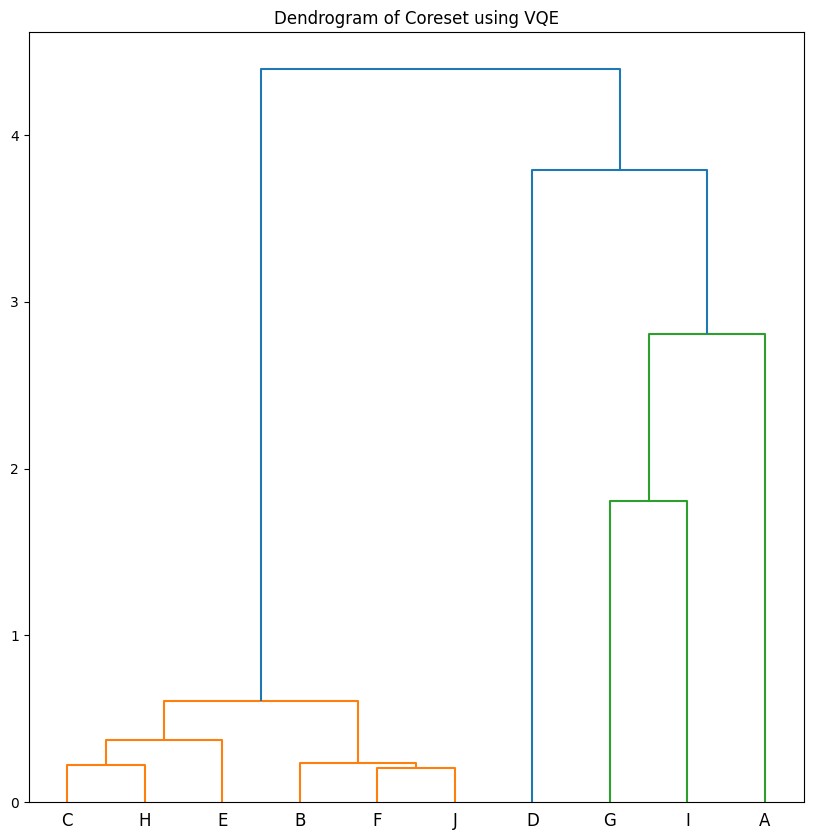

In [128]:
dendo = Dendrogram(coreset_df, hierarchial_clustering_sequence)
dendo.plot_dendrogram(plot_title="Dendrogram of Coreset using VQE")

Each branch point in the dendrogram aboves corresponds to one of the plots below. Notice the first iterations are the most complicated, and the final iterations become trivial bipartitioning of two points. Occasionally, especially in the first iteration, the partitioning might be puzzling at first glance. The data might seem to naturally cluster into two groups. However, there are cases where a stray point seems to belong in the wrong cluster. There are two explanations for this. 1) The quantum sampling is approximate and stochastic. It is possible that too few shots were taken to sample the ground state of the problem. 2) It is important to remember that we are clustering coresets and not data points. There can be cases where it is optimal to pay a penalty by excluding a point based on proximity if the weights are small enough that the penalty has less impact. Usually, if a point looks unusually clustered and you go look at the original coresets plotted above, that point will have a small weight.

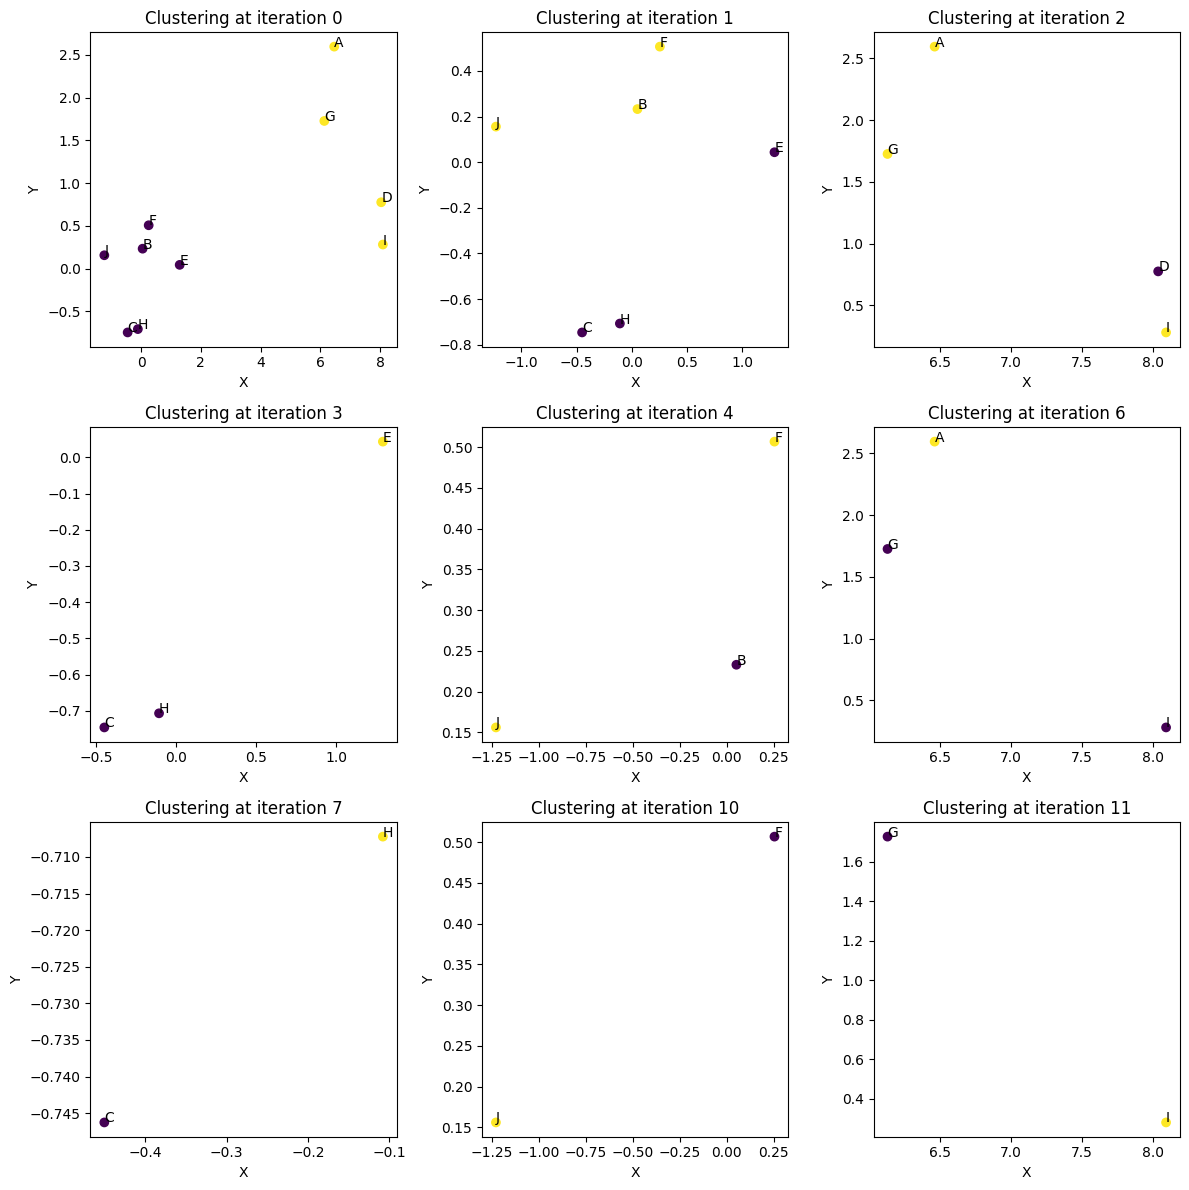

In [129]:
Dendrogram.plot_hierarchial_split(hierarchial_clustering_sequence, coreset_df)

The hierarchical clustering can be converted to flat clustering by drawing a line perpendicular to the branches. Any data point that intersects the line is considered to be in the same cluster. The function below performs this task at threshold height of 1.5. If you want to use the number of clusters instead of height, you can use ```dendo.get_clusters_using_k()``` method. You pass the number of desired clusters as an argument. The figure below shows the clusters that are formed at threshold height of 1.5.

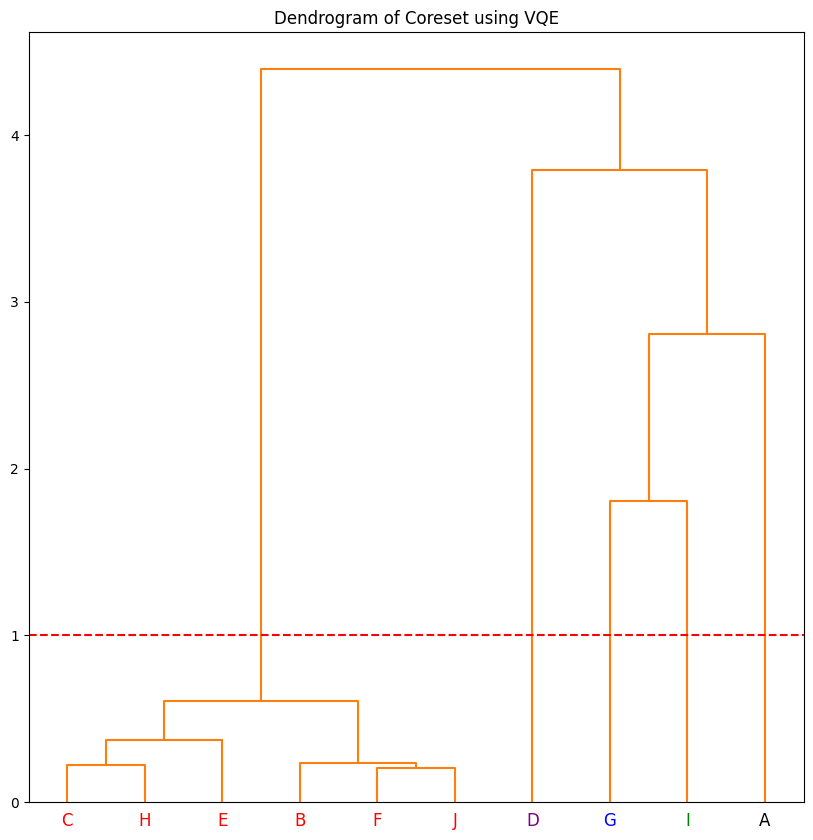

In [130]:
threshold_height = 1
clusters = dendo.get_clusters_using_height(threshold_height)
colors = ["red", "blue", "green", "black", "purple", "orange", "yellow"]
dendo.plot_dendrogram(
    plot_title="Dendrogram of Coreset using VQE",
    colors=colors,
    clusters=clusters,
    color_threshold=threshold_height,
)

You can visualize the flat clusters using ```dendo.plot_clusters()``` method. The function takes the clusters and colors as arguments. The clusters are represented by different colors

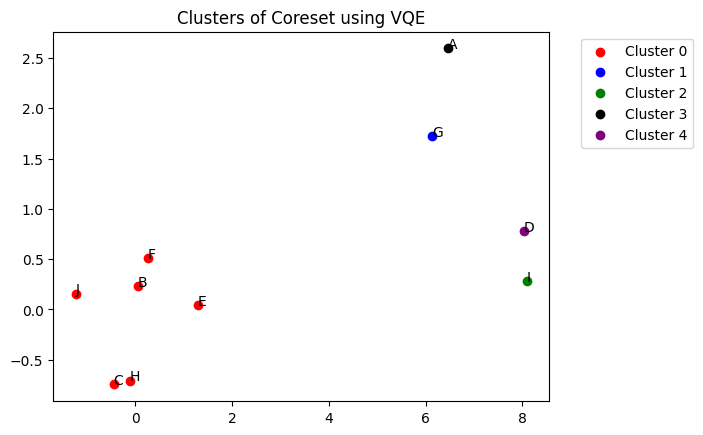

In [131]:
dendo.plot_clusters(clusters,
                    colors,
                    plot_title="Clusters of Coreset using VQE",
                    show_annotation=True)

The function below uses the ```dendo.get_voronoi_tessalation()``` method to convert the clusters into regions. ```coreset_df```,``` clusters``` and ```colors``` need to be passed as the arguments to create the regions. This function creates a region for each coreset point separately and then colors them according to the clusters with colors passed as arguments. Another option is to create regions using the centroids of the clusters. You need to pass ```tesslation_by_cluster=True``` to the function to perform this task.

Once the region creation is complete, you can use ```plot_voironi()``` method to plot the regions. The function takes the clusters and colors as arguments.

Remembering that these regions were based on coresets, they can overlay the original data set and be used to cluster the data based on the coreset analysis.

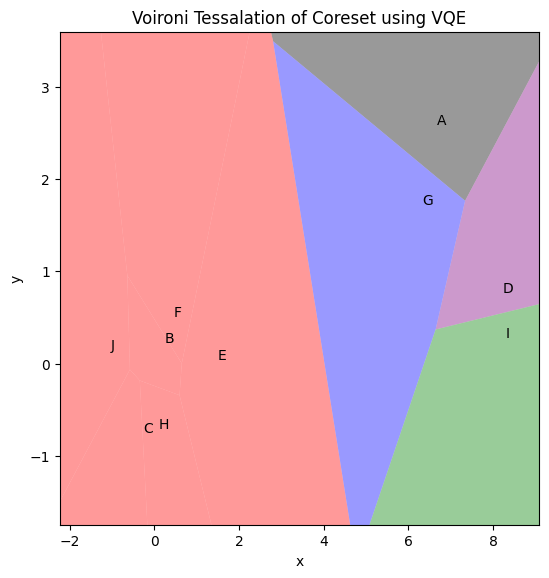

In [132]:
vt = Voironi_Tessalation(coreset_df,
                         clusters,
                         colors,
                         tesslation_by_cluster=False)
vt.plot_voironi(plot_title="Voironi Tessalation of Coreset using VQE",
                show_annotation=True)